In [1]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
import keras
from keras.layers import LSTM, Dense, Dropout, LeakyReLU, GRU, BatchNormalization,  Flatten, MaxPooling2D, TimeDistributed, ConvLSTM1D, Input
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
sys.path.append(str(Path("../../..").resolve()))
from src.constants import model_data_dir


In [22]:
remove_cols = ["sc_1d_fwd_rel_d", "mom_1d_fwd_rel_d"]

df_train = pd.read_csv(model_data_dir / "train_classification.csv").drop(remove_cols + ["date"], axis=1)
df_train = df_train[[c for c in df_train.columns if c.find("mv_") == -1]]
df_test = pd.read_csv(model_data_dir / "test_classification.csv").drop(remove_cols, axis=1)
df_test = df_test[[c for c in df_test.columns if c.find("mv_") == -1]]



test_dates = pd.to_datetime(df_test["date"])
df_test = df_test.drop("date", axis=1)

In [23]:
((y_train, x_train), (y_test, x_test)) = ((df_train.pop("value_1d_fwd_rel_d"), df_train), (df_test.pop("value_1d_fwd_rel_d"), df_test))

In [24]:
win_length = 40
batch_size = 180
num_features = x_train.shape[1]
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)


In [27]:
df_train

,vix,v2x,move,gold_vol,jpm_global_fx_vol,jpm_g7_fx_vol,jpm_em_fx_vol,eurusd_1m_vol,usdjpy_1m_vol,usd_libor_swaption_vol,...,usd_libor_swaption_vol_rolling_40,s&p_500_vrp_rolling_40,s&p_500_skew_rolling_40,eurusd_risk_reversal_rolling_40,usdjpy_risk_reversal_rolling_40,eurjpy_risk_reversal_rolling_40,month,year,day,weekday
0,-0.0226,-0.2933,0.0751,-0.3871,0.2132,0.4609,-0.7858,0.4775,0.2698,-1.2457,...,-0.6174,-1.0756,-0.9366,-0.2222,-0.1303,-0.0519,7,2000,26,2
1,-0.0305,-0.2347,0.0167,-0.5660,0.2132,0.4648,-0.7975,0.3823,0.2698,-1.2551,...,-0.6174,-1.0756,-0.9314,-0.2176,-0.1166,-0.0524,7,2000,27,3
2,0.1082,-0.1098,0.0003,-0.5960,0.2247,0.4727,-0.7681,0.4299,0.2859,-1.2551,...,-0.6167,-1.0756,-0.9371,-0.2136,-0.1048,-0.0538,7,2000,28,4
3,0.0970,-0.1387,0.0321,-0.5960,0.2477,0.5003,-0.7828,0.4934,0.3020,-1.2504,...,-0.6160,-1.0756,-0.9334,-0.2101,-0.0945,-0.0510,7,2000,31,0
4,0.0758,-0.1185,0.0414,0.3059,0.2362,0.4885,-0.7828,0.4299,0.2859,-1.2457,...,-0.6160,-1.0756,-0.9269,-0.2067,-0.0857,-0.0499,8,2000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,-0.8267,4.2335,-0.5860,-0.0560,-0.5578,-0.5455,-0.3563,-0.9052,-0.2861,-0.0529,...,-0.3441,-0.5041,0.3971,-0.2911,-0.2323,-0.2626,12,2013,24,1
3375,-0.8434,4.1364,-0.6184,-0.0739,-0.5003,-0.4745,-0.3504,-0.8901,-0.1405,-0.0038,...,-0.3359,-0.4979,0.4254,-0.2935,-0.2309,-0.2627,12,2013,26,3
3376,-0.8289,-0.6944,-0.6483,-0.1271,-0.4504,-0.4311,-0.2887,-0.7480,-0.0415,0.0248,...,-0.3298,-0.4907,0.4523,-0.2941,-0.2283,-0.2627,12,2013,27,4
3377,-0.7059,-0.6184,-0.5444,-0.1128,-0.4427,-0.4192,-0.2916,-0.5353,-0.0962,0.0031,...,-0.3184,-0.4901,0.4620,-0.2940,-0.2251,-0.2629,12,2013,30,0


## Conv LSTM

In [229]:
model = Sequential()
model.add(Input(shape = ( win_length, num_features, 1)))
model.add(ConvLSTM1D(filters=64, kernel_size=2, padding='same', return_sequences=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(ConvLSTM1D(filters=64, kernel_size=2, padding='same', return_sequences=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(ConvLSTM1D(filters=64, kernel_size=2, padding='same', return_sequences=False))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(Flatten())
model.add(Dense(10))
model.add(Dense(1, activation="sigmoid"))

In [230]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                            patience = 20)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stop])

Epoch 1/50
19/19 [==============================] - 164s 8s/step - loss: 0.6914 - accuracy: 0.5399 - val_loss: 0.6965 - val_accuracy: 0.4858
Epoch 2/50
19/19 [==============================] - 152s 8s/step - loss: 0.6844 - accuracy: 0.5566 - val_loss: 0.6991 - val_accuracy: 0.4901
Epoch 3/50
19/19 [==============================] - 150s 8s/step - loss: 0.6802 - accuracy: 0.5688 - val_loss: 0.6996 - val_accuracy: 0.4918
Epoch 4/50
19/19 [==============================] - 151s 8s/step - loss: 0.6775 - accuracy: 0.5759 - val_loss: 0.7033 - val_accuracy: 0.4874
Epoch 5/50
19/19 [==============================] - 1034s 57s/step - loss: 0.6710 - accuracy: 0.5870 - val_loss: 0.7134 - val_accuracy: 0.4995
Epoch 6/50
16/19 [========================>.....] - ETA: 1:28 - loss: 0.6702 - accuracy: 0.5889

KeyboardInterrupt: 

## LSTM

In [25]:
model = Sequential()
model.add(Input(shape=(win_length, num_features)))
model.add(LSTM(64, return_sequences=True, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(LSTM(32, return_sequences=False, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1, activation="sigmoid"))

In [28]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                            patience = 20)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=SGD(learning_rate=0.01, momentum=0.05),
              metrics=["accuracy"])

history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stop])

Epoch 1/50
19/19 [==============================] - 3s 93ms/step - loss: 0.6906 - accuracy: 0.5439 - val_loss: 0.6999 - val_accuracy: 0.4875
Epoch 2/50
19/19 [==============================] - 1s 75ms/step - loss: 0.6934 - accuracy: 0.5337 - val_loss: 0.6999 - val_accuracy: 0.4875
Epoch 3/50
19/19 [==============================] - 1s 77ms/step - loss: 0.6938 - accuracy: 0.5322 - val_loss: 0.6997 - val_accuracy: 0.4875
Epoch 4/50
19/19 [==============================] - 1s 77ms/step - loss: 0.6912 - accuracy: 0.5367 - val_loss: 0.6999 - val_accuracy: 0.4875
Epoch 5/50
19/19 [==============================] - 1s 75ms/step - loss: 0.6917 - accuracy: 0.5418 - val_loss: 0.7000 - val_accuracy: 0.4875
Epoch 6/50
19/19 [==============================] - 1s 79ms/step - loss: 0.6913 - accuracy: 0.5322 - val_loss: 0.7000 - val_accuracy: 0.4875
Epoch 7/50
19/19 [==============================] - 2s 101ms/step - loss: 0.6915 - accuracy: 0.5433 - val_loss: 0.7000 - val_accuracy: 0.4875
Epoch 8/50
1

KeyboardInterrupt: 

In [9]:
predictions = model.predict_generator(test_generator)
df_preds = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds["yhat"] = predictions.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_53369/953353012.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


<AxesSubplot:>

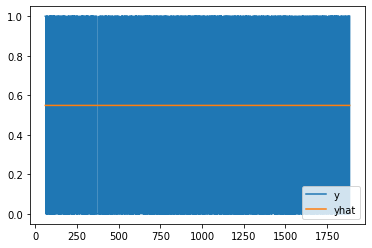

In [10]:
df_preds[["y", "yhat"]].plot()

## GRU 

In [11]:
model_gru = Sequential()
model_gru.add(GRU(256, input_shape= (win_length, num_features), return_sequences=True))
model_gru.add(LeakyReLU(alpha=0.5)) 
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(GRU(128, input_shape= (win_length, num_features), return_sequences=True))
model_gru.add(LeakyReLU(alpha=0.5)) 
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(LSTM(32, input_shape= (win_length, num_features), return_sequences=False))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(Dense(1, activation="sigmoid"))

In [12]:
early_stop_gru = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 20)

model_gru.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history_gru = model_gru.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False, callbacks=[early_stop_gru])

Epoch 1/50
19/19 [==============================] - 11s 460ms/step - loss: 0.8842 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4858
Epoch 2/50
19/19 [==============================] - 9s 481ms/step - loss: 0.8359 - accuracy: 0.5110 - val_loss: 0.6946 - val_accuracy: 0.4852
Epoch 3/50
19/19 [==============================] - 10s 532ms/step - loss: 0.8108 - accuracy: 0.5053 - val_loss: 0.6942 - val_accuracy: 0.4852
Epoch 4/50
19/19 [==============================] - 10s 509ms/step - loss: 0.7760 - accuracy: 0.5137 - val_loss: 0.6958 - val_accuracy: 0.4852
Epoch 5/50
19/19 [==============================] - 10s 516ms/step - loss: 0.7710 - accuracy: 0.5095 - val_loss: 0.6938 - val_accuracy: 0.4852
Epoch 6/50
19/19 [==============================] - 10s 509ms/step - loss: 0.7523 - accuracy: 0.5077 - val_loss: 0.6967 - val_accuracy: 0.4852
Epoch 7/50
19/19 [==============================] - 8s 443ms/step - loss: 0.7424 - accuracy: 0.5110 - val_loss: 0.7069 - val_accuracy: 0.4852
E

KeyboardInterrupt: 

In [237]:
predictions_gru = model_gru.predict_generator(test_generator)
df_preds_gru = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds_gru["yhat"] = predictions_gru.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_73342/2811852203.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_gru = model_gru.predict_generator(test_generator)


<AxesSubplot:>

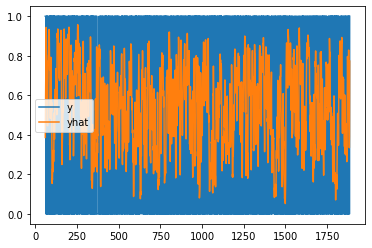

In [238]:
df_preds_gru[["y", "yhat"]].plot()

In [ ]:
predictions_gru = model_gru.predict_generator(test_generator)

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_73342/303773502.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_gru = model_gru.predict_generator(test_generator)


In [ ]:
preds = predictions_gru.flatten()
(np.where(preds > 0.5, 1, 0) == y_test[win_length:]).mean()

0.48504273504273504

In [ ]:
remove_cols = ["sc_1d_fwd_rel_d", "mom_1d_fwd_rel_d"]

df_train = pd.read_csv(model_data_dir / "train_classification.csv").drop(remove_cols + ["Date"], axis=1)
df_test = pd.read_csv(model_data_dir / "test_classification.csv").drop(remove_cols, axis=1)
test_dates = pd.to_datetime(df_test["Date"])
df_test.drop("Date", axis=1, inplace=True)